В даннном проекте бует произведен анализ датасета youtube, а также построена модель на случайном лесе, которая сможет давать примерный прогноз по просмотрам

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [36]:
df = pd.read_csv("youtube_data.csv")

Предобработка данных

In [41]:
def parse_duration(duration):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration)
    if not match:
       return 0
    hours = int(match.group(1) or 0)
    minutes = int(match.group(2) or 0)
    seconds = int(match.group(3) or 0)
    return hours * 3600 + minutes * 60 + seconds

df['duration_seconds'] = df['duration'].fillna('PT0S').apply(parse_duration)

#обработка дат
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df['publish_hour'] = df['published_date'].dt.hour
df['publish_dayofweek'] = df['published_date'].dt.dayofweek

df['title_len'] = df['title'].astype(str).apply(len)
df['desc_len'] = df['description'].astype(str).apply(len)

#подсчет кол-ва тегов у видео
df['tag_count'] = df['tags'].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0)
#заполнение пропусков
df['like_count'] = df['like_count'].fillna(0)
df['comment_count'] = df['comment_count'].fillna(0)

#удаление строк без просмотров
df = df[df['view_count'].notnull()]

Анализ и визуализация

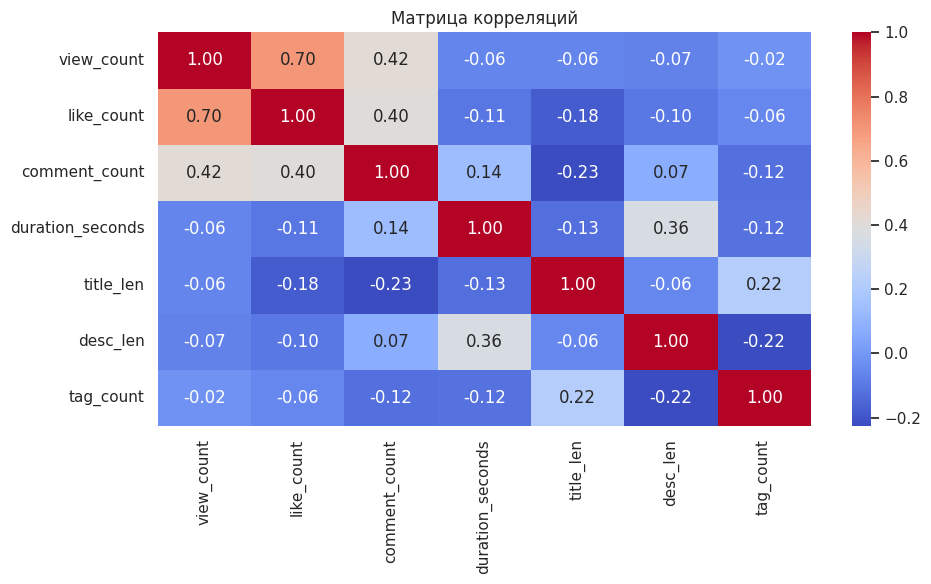

In [43]:
plt.figure(figsize=(10,6))
corr_matrix = df[['view_count', 'like_count', 'comment_count', 'duration_seconds', 'title_len', 'desc_len', 'tag_count']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

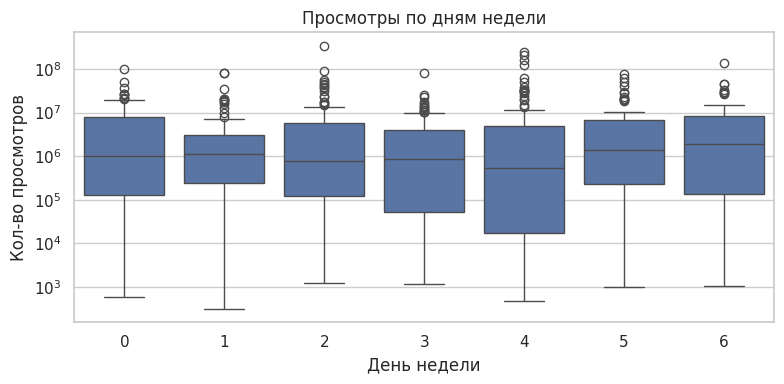

In [40]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='publish_dayofweek', y='view_count')
plt.yscale('log')
plt.title('Просмотры по дням недели')
plt.xlabel('День недели')
plt.ylabel('Кол-во просмотров')
plt.tight_layout()
plt.show()

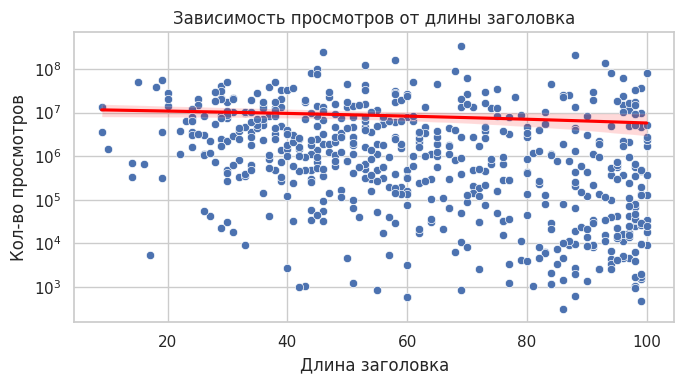

In [42]:
plt.figure(figsize=(7,4))
sns.scatterplot(data=df, x='title_len', y='view_count')
sns.regplot(data=df, x='title_len', y='view_count', scatter=False, color='red')
plt.yscale('log')
plt.title('Зависимость просмотров от длины заголовка')
plt.xlabel('Длина заголовка')
plt.ylabel('Кол-во просмотров')
plt.tight_layout()
plt.show()

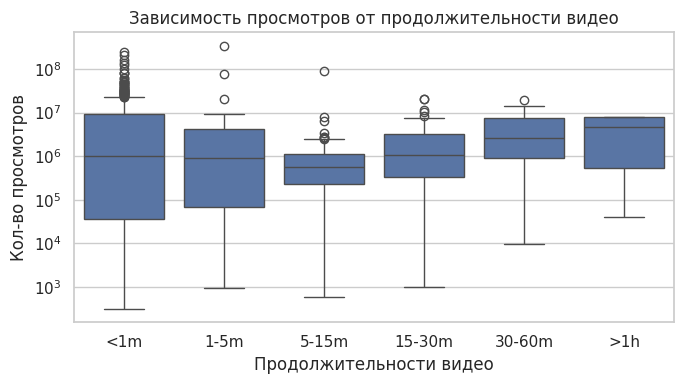

In [44]:
df['duration_bucket'] = pd.cut(df['duration_seconds'], bins=[0,60,300,900,1800,3600,10000], labels=['<1m','1-5m','5-15m','15-30m','30-60m','>1h'])
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x='duration_bucket', y='view_count')
plt.yscale('log')
plt.title('Зависимость просмотров от продолжительности видео')
plt.xlabel('Продолжительности видео')
plt.ylabel('Кол-во просмотров')
plt.tight_layout()
plt.show()

Обучение модели

In [12]:
features = [
'duration_seconds', 'publish_hour', 'publish_dayofweek',
'title_len', 'desc_len', 'tag_count',
'like_count', 'comment_count'
]
X = df[features]
y = df['view_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Оценка модели

In [16]:
y_pred = model.predict(X_test)

print("--- Evaluation ---")
print(f"R^2 Score: {r2_score(y_test, y_pred):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):,.0f} views")

--- Evaluation ---
R^2 Score: 0.67
MAE: 5,314,449 views


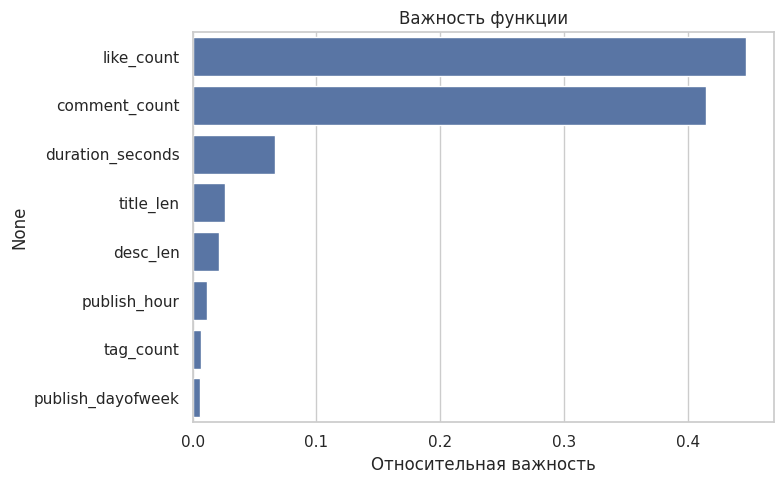

In [45]:
feat_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Важность функции")
plt.xlabel("Относительная важность")
plt.tight_layout()
plt.show()

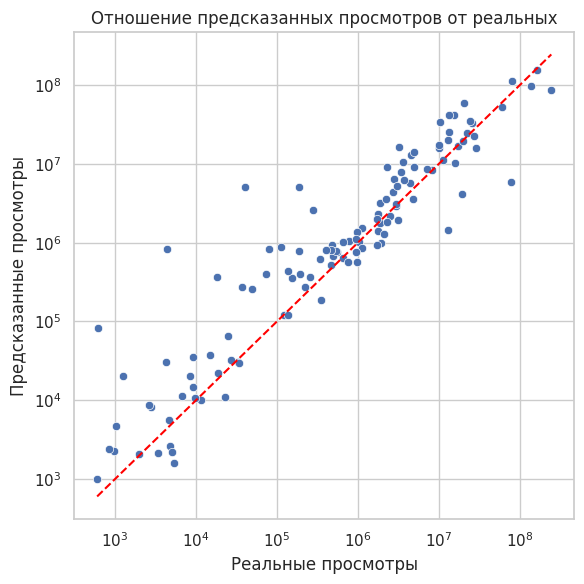

In [46]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Реальные просмотры")
plt.ylabel("Предсказанные просмотры")
plt.title("Отношение предсказанных просмотров от реальных")
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()